In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [4]:
# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
    
    def forward(self, x):
        return self.net(x)



Epoch 0, Loss: 0.014989, Residual Loss: 0.000000, Data Loss: 0.011794
Epoch 100, Loss: 0.001681, Residual Loss: 0.000000, Data Loss: 0.001334
Epoch 200, Loss: 0.000027, Residual Loss: 0.000000, Data Loss: 0.000023
Epoch 300, Loss: 0.000002, Residual Loss: 0.000000, Data Loss: 0.000002
Epoch 400, Loss: 0.000001, Residual Loss: 0.000000, Data Loss: 0.000001
Epoch 500, Loss: 0.000000, Residual Loss: 0.000000, Data Loss: 0.000000
Epoch 600, Loss: 0.000000, Residual Loss: 0.000000, Data Loss: 0.000000
Epoch 700, Loss: 0.000000, Residual Loss: 0.000000, Data Loss: 0.000000
Epoch 800, Loss: 0.000000, Residual Loss: 0.000000, Data Loss: 0.000000
Epoch 900, Loss: 0.000000, Residual Loss: 0.000000, Data Loss: 0.000000


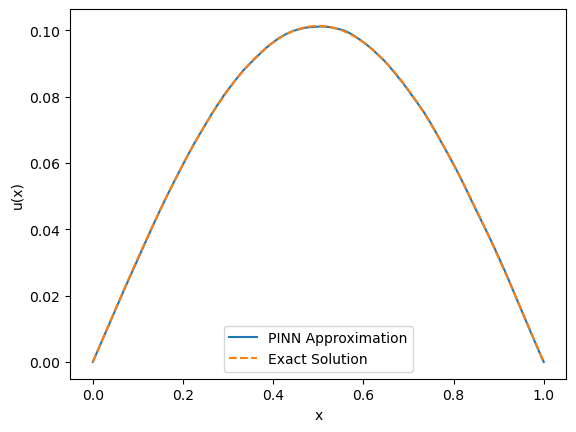

In [5]:
# Function to compute the second derivative using automatic differentiation
def compute_residual(model, x):
    u = model(x)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    return u_xx  # Corrected: removed the negative sign to get the actual second derivative

# Generate a few data points for u(x)
def generate_data_points(n_points):
    # Assume we know the values of u at some points in the domain
    x_data = torch.linspace(0, 1, n_points).view(-1, 1)
    u_data = torch.sin(np.pi * x_data) / (np.pi**2)  # Analytical solution at data points
    return x_data, u_data

# Create the collocation points in the domain [0, 1]
def generate_collocation_points(n_points):
    return torch.linspace(0, 1, n_points).view(-1, 1).requires_grad_(True)


# Define the boundary conditions
def boundary_loss(model):
    u_0 = model(torch.tensor([[0.0]], dtype=torch.float32))
    u_1 = model(torch.tensor([[1.0]], dtype=torch.float32))
    return u_0**2 + u_1**2  # Penalize deviation from u(0)=0 and u(1)=0


# Training function
def train_pinn(model, n_data_points, n_collocation_points, epochs, lr, lambda_pde, lambda_data, lambda_boundary):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    # Known data points
    x_data, u_data = generate_data_points(n_data_points)
    
    # Collocation points for enforcing PDE
    collocation_points = generate_collocation_points(n_collocation_points)
    
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model = None
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Residual loss from PDE at collocation points
        residual = compute_residual(model, collocation_points)
        loss_residual = torch.mean(residual**2)
        
        # Data loss from known points
        u_pred = model(x_data)
        loss_data = F.mse_loss(u_pred, u_data)

        # Boundary loss
        loss_boundary = boundary_loss(model)
        
        # Total loss with weighting
        loss = lambda_pde * loss_residual + lambda_data * loss_data + lambda_boundary * loss_boundary
        loss.backward()
        optimizer.step()
        
        if loss < best_loss:
            best_loss = loss
            epochs_no_improve = 0
            best_model = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= 100:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model)
            break
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Residual Loss: {loss_residual.item():.6f}, Data Loss: {loss_data.item():.6f}")
    
    return model

# Initialize the model
model = PINN()

# Training settings
n_data_points = 30  # Number of known data points
n_collocation_points = 100  # Number of collocation points
epochs = 1000
learning_rate = 0.0001  # Use a smaller learning rate to see if learning improves
lambda_pde = 1.0  # Weight for the physics loss
lambda_data = 1.0  # Weight for the data loss
lambda_boundary = 1.0  # Weight for the boundary loss
# Train the model
trained_model = train_pinn(model, n_data_points, n_collocation_points, epochs, learning_rate, lambda_pde, lambda_data, lambda_boundary)

# Plotting the result
x_test = torch.linspace(0, 1, 100).view(-1, 1)
u_pred = trained_model(x_test).detach().numpy()

# Exact solution for comparison: u_exact(x) = sin(pi x) / (pi^2)
u_exact = torch.sin(np.pi * x_test) / (np.pi**2)

plt.plot(x_test, u_pred, label='PINN Approximation')
plt.plot(x_test, u_exact, label='Exact Solution', linestyle='--')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()


Epoch 0, Total Loss: 0.174361, Residual Loss: 0.000031, Boundary Loss: 0.035942, Initial Loss: 0.138389
Epoch 100, Total Loss: 0.093616, Residual Loss: 0.006207, Boundary Loss: 0.025524, Initial Loss: 0.061884
Epoch 200, Total Loss: 0.033872, Residual Loss: 0.004247, Boundary Loss: 0.012212, Initial Loss: 0.017413
Epoch 300, Total Loss: 0.017523, Residual Loss: 0.004307, Boundary Loss: 0.006849, Initial Loss: 0.006367
Epoch 400, Total Loss: 0.014185, Residual Loss: 0.003270, Boundary Loss: 0.005979, Initial Loss: 0.004936
Epoch 500, Total Loss: 0.019570, Residual Loss: 0.003300, Boundary Loss: 0.010643, Initial Loss: 0.005628
Epoch 600, Total Loss: 0.011969, Residual Loss: 0.002604, Boundary Loss: 0.005263, Initial Loss: 0.004102
Epoch 700, Total Loss: 0.011171, Residual Loss: 0.002334, Boundary Loss: 0.005033, Initial Loss: 0.003804
Epoch 800, Total Loss: 0.010514, Residual Loss: 0.002191, Boundary Loss: 0.004806, Initial Loss: 0.003517
Epoch 900, Total Loss: 0.009838, Residual Loss: 

/home/dipplestix/Projects/paper_reimps/.conda/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1728945388038/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


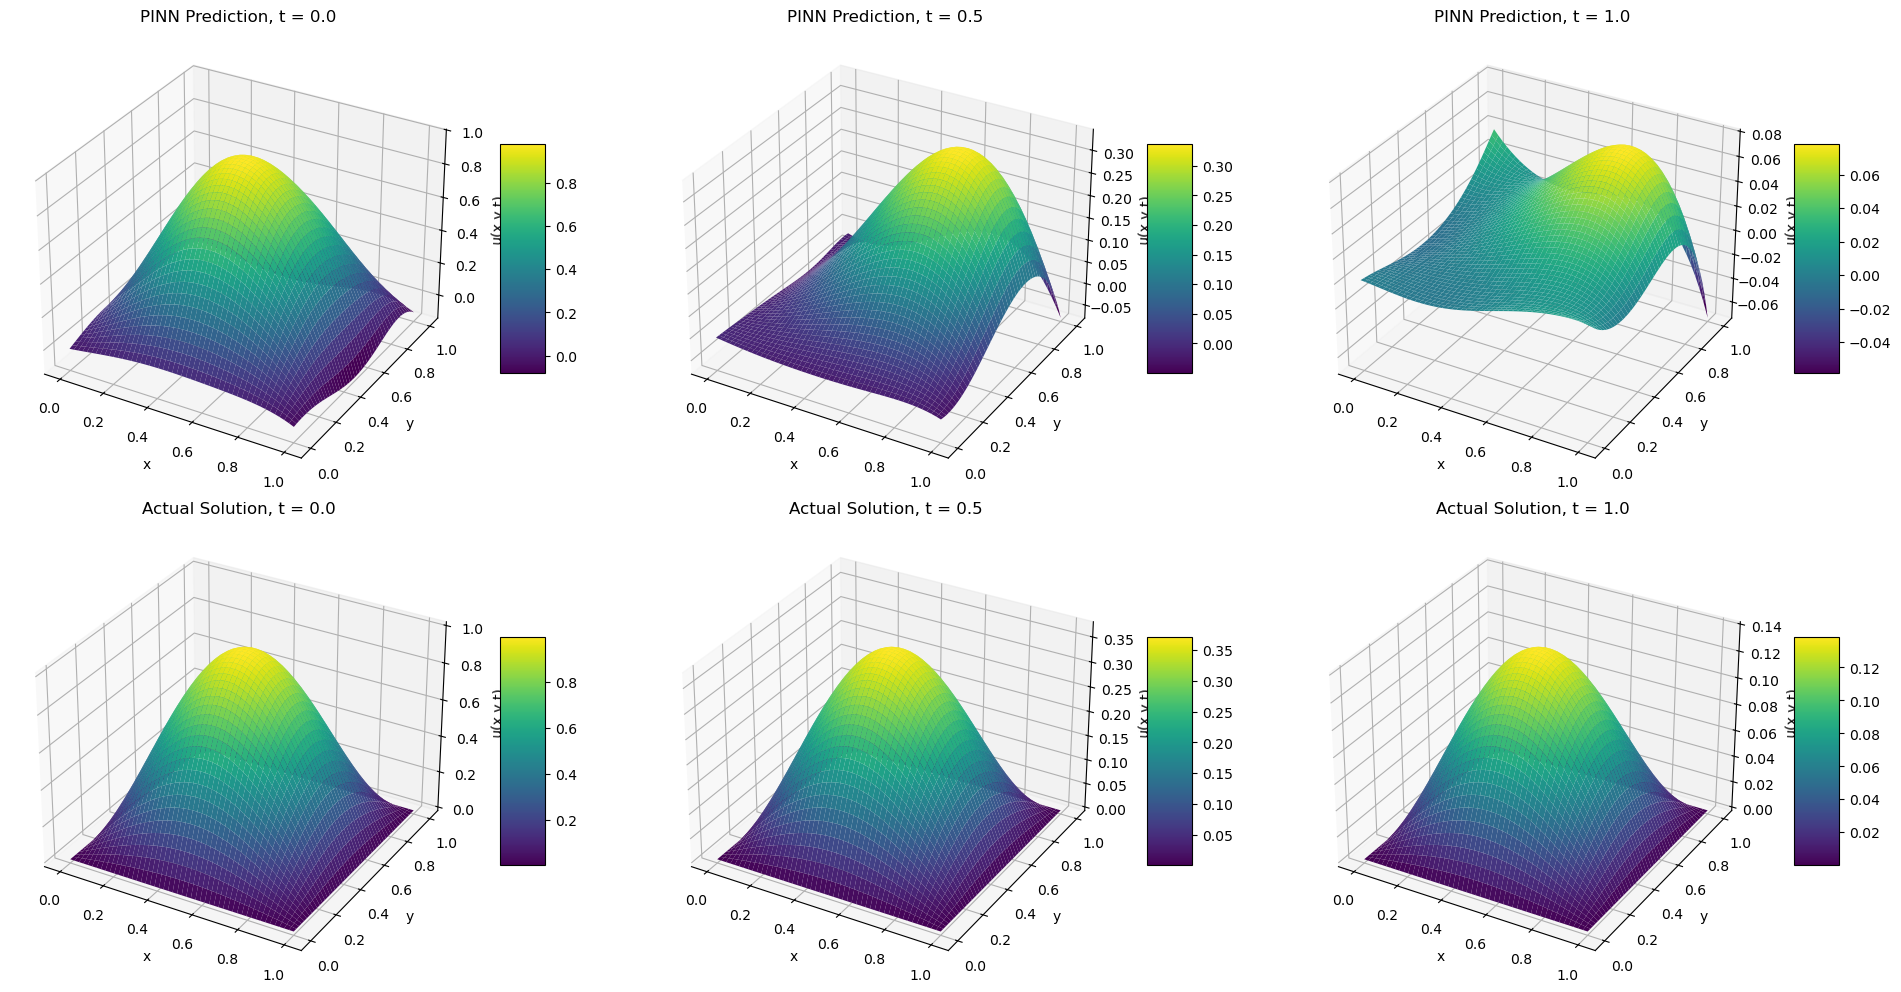

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class AdvancedPINN(nn.Module):
    def __init__(self):
        super(AdvancedPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)
        return self.net(inputs)

def pde_residual(model, x, y, t):
    u = model(x, y, t)
    
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    # Heat equation with advection: u_t + c(u_x + u_y) = k(u_xx + u_yy)
    c = 0.5  # advection coefficient
    k = 0.1  # diffusion coefficient
    residual = u_t + c*(u_x + u_y) - k*(u_xx + u_yy)
    
    return residual

def generate_dataset(n_interior, n_boundary, n_initial):
    # Interior points
    x_interior = torch.rand(n_interior, 1)
    y_interior = torch.rand(n_interior, 1)
    t_interior = torch.rand(n_interior, 1)
    
    # Boundary points (u = 0 at x = 0, x = 1, y = 0, y = 1)
    x_boundary = torch.cat([torch.zeros(n_boundary//4, 1), torch.ones(n_boundary//4, 1), 
                            torch.rand(n_boundary//4, 1), torch.rand(n_boundary//4, 1)])
    y_boundary = torch.cat([torch.rand(n_boundary//4, 1), torch.rand(n_boundary//4, 1), 
                            torch.zeros(n_boundary//4, 1), torch.ones(n_boundary//4, 1)])
    t_boundary = torch.rand(n_boundary, 1)
    
    # Initial condition points (u = sin(πx) * sin(πy) at t = 0)
    x_initial = torch.rand(n_initial, 1)
    y_initial = torch.rand(n_initial, 1)
    t_initial = torch.zeros(n_initial, 1)
    u_true_initial = torch.sin(np.pi * x_initial) * torch.sin(np.pi * y_initial)
    
    return (x_interior, y_interior, t_interior), (x_boundary, y_boundary, t_boundary), (x_initial, y_initial, t_initial, u_true_initial)

def train_advanced_pinn(model, dataset, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    (x_interior, y_interior, t_interior), (x_boundary, y_boundary, t_boundary), (x_initial, y_initial, t_initial, u_true_initial) = dataset
    
    x_interior.requires_grad = True
    y_interior.requires_grad = True
    t_interior.requires_grad = True
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Residual loss
        loss_residual = torch.mean(pde_residual(model, x_interior, y_interior, t_interior)**2)
        
        # Boundary loss
        u_boundary = model(x_boundary, y_boundary, t_boundary)
        loss_boundary = torch.mean(u_boundary**2)
        
        # Initial condition loss
        u_initial = model(x_initial, y_initial, t_initial)
        loss_initial = torch.mean((u_initial - u_true_initial)**2)
        
        # Total loss
        loss = loss_residual + loss_boundary + loss_initial
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}, Residual Loss: {loss_residual.item():.6f}, Boundary Loss: {loss_boundary.item():.6f}, Initial Loss: {loss_initial.item():.6f}")
    
    return model

# Initialize the model
model = AdvancedPINN()

# Generate dataset
n_interior, n_boundary, n_initial = 5000, 1000, 1000
dataset = generate_dataset(n_interior, n_boundary, n_initial)

# Training settings
epochs = 5000
learning_rate = 0.001

# Train the model
trained_model = train_advanced_pinn(model, dataset, epochs, learning_rate)

# Plotting the results
x = torch.linspace(0, 1, 50)
y = torch.linspace(0, 1, 50)
t = torch.tensor([0.0, 0.5, 1.0])

X, Y = torch.meshgrid(x, y)
X_flat = X.reshape(-1, 1)
Y_flat = Y.reshape(-1, 1)

fig = plt.figure(figsize=(20, 10))

for i, t_val in enumerate(t):
    T_flat = t_val * torch.ones_like(X_flat)
    U_pred = trained_model(X_flat, Y_flat, T_flat).detach().numpy().reshape(50, 50)
    
    # Calculate the actual solution
    U_actual = np.exp(-2 * np.pi**2 * 0.1 * t_val.item()) * np.sin(np.pi * X.numpy()) * np.sin(np.pi * Y.numpy())
    
    # PINN prediction
    ax1 = fig.add_subplot(2, 3, i+1, projection='3d')
    surf1 = ax1.plot_surface(X.numpy(), Y.numpy(), U_pred, cmap='viridis')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u(x,y,t)')
    ax1.set_title(f'PINN Prediction, t = {t_val.item()}')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
    
    # Actual solution
    ax2 = fig.add_subplot(2, 3, i+4, projection='3d')
    surf2 = ax2.plot_surface(X.numpy(), Y.numpy(), U_actual, cmap='viridis')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('u(x,y,t)')
    ax2.set_title(f'Actual Solution, t = {t_val.item()}')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()
